In this notebook, we are going to build a neural network(multilayer perceptron) using FastAI v2 and Pytorch and successfully train it to recognize digits in the image. [Pytorch](https://pytorch.org/) is a very popular deep learning framework released by Facebook, and [FastAI v2](https://docs.fast.ai/) is a library which simplifies training fast and accurate neural nets using modern best practices. It's based on research into deep learning best practices undertaken at [fast.ai](https://www.fast.ai/), including "out of the box" support for vision, text, tabular, and collab (collaborative filtering) models. If you're looking for the source code, head over to the [fastai repo](https://github.com/fastai/fastai) on GitHub. This notebook will guide for build a neural network with this library. If you want to understand what is a Multi-layer perceptron, you can look at my [previous notebook](https://github.com/aayushmnit/Deep_learning_explorations/blob/master/1_MLP_from_scratch/Building_neural_network_from_scratch.ipynb) where I built a Multi-layer perceptron from scratch using numpy and [other notebook](https://github.com/aayushmnit/Deep_learning_explorations/blob/master/2_MLP_tensorflow/my1stNN.ipynb) where I built the same model using TensorFlow. As you will notice, the amount of code which is needed to write this notebook is way less than what's been used in previous notebooks, all thanks to fastai library which lets us focus more on solving problems than writing code.



## BoilerPlate command

It’s standard practice to start the notebook with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.



In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Importing Fast AI library

Let’s import fastai library and define our batch_size parameter to 128. Usually, image databases are enormous, so we need to feed these images into a GPU using batches, batch size 128 means that we will feed 128 images at once to update parameters of our deep learning model. If you are running out of memory because of smaller GPU RAM, you can reduce batch size to 64 or 32.

In [2]:
from fastai.vision.all import *
bs=256

## Downloading Dataset

We will start by downloading MNIST handwritten dataset from [fastai dataset](https://course.fast.ai/datasets) page. MNIST is a standard dataset of small (28x28) handwritten grayscale digits, developed in the 1990s for testing the most sophisticated models of the day; today, often used as a basic “hello world” for introducing deep learning. This fast.ai datasets version uses a standard PNG format instead of the special binary format of the original so that you can use the regular data pipelines in most libraries; if you want to use just a single input channel like the original, simply pick a single slice from the channels axis.

In [3]:
path = untar_data(URLs.MNIST, dest="../data/");
path

Path('../data/mnist_png')

By running the above command, the data is downloaded and stored in the path shown above. Let's look at how the data directory is set up as we have to import data from these directories. Let's start by looking at path directory, and we can see below that our data already have training and testing folder.

In [4]:
path.ls()

(#3) [Path('../data/mnist_png/models'),Path('../data/mnist_png/testing'),Path('../data/mnist_png/training')]

Let's look inside the training folder. Data is split by digits 1 to 9 in a different folder.

In [5]:
(path/'training').ls()

(#10) [Path('../data/mnist_png/training/0'),Path('../data/mnist_png/training/1'),Path('../data/mnist_png/training/2'),Path('../data/mnist_png/training/3'),Path('../data/mnist_png/training/4'),Path('../data/mnist_png/training/5'),Path('../data/mnist_png/training/6'),Path('../data/mnist_png/training/7'),Path('../data/mnist_png/training/8'),Path('../data/mnist_png/training/9')]

Within each digit folder, we have images.

In [6]:
(path/'training/0').ls()[1:5]

(#4) [Path('../data/mnist_png/training/0/1000.png'),Path('../data/mnist_png/training/0/10005.png'),Path('../data/mnist_png/training/0/10010.png'),Path('../data/mnist_png/training/0/10022.png')]

## Importing Data

Now we have an understanding of how our data directory is set up; we will use FastAI amazing [data block API](https://docs.fast.ai/vision.data) to import data and FastAI [image transformation functions](https://docs.fast.ai/vision.transform.html) to do data augmentation. Let's start by defining what transformation we want to do.

In [7]:
ds_tfms = aug_transforms(do_flip=False, max_rotate=15, max_zoom=1.1, max_lighting=0.2, max_warp=0.2)

In **get_transforms** function, we can define all the transformations we want to do. FastAI makes doing data augmentation incredibly easy as all the transformation can be passed in one function and uses an incredibly fast implementation. Let's look at each argument given in the function.

- *do_flip=False, flip_vert=False*: We don't want to flip digits in both vertical and horizontal direction as that is not a good idea with digit data. 
- *max_rotate= 15*: Rotates images randomly while importing by a maximum of 15 degrees in both clockwise and anti-clockwise direction
- *max_zoom=1.1*: Zoomin/Zoomout images by 10% of the original image 
- *max_lighting=0.2*: Random lightning and contrast change controlled by max_lighting will be applied
- *max_warp=0.2*: Random symmetric warp of magnitude between -max_warp and +max_warp is applied with probability p_affine which is defaulted to 0.75 in this case.

Now that we have defined what transformation we want to do on our input images let's start by defining out data batches or databunch as FastAI will call it. Image data sets are massive in size, so we never want to import the entire dataset in memory, instead of that we define a databunch which will let us load batches of data and do required transformation on the fly.

In [8]:
dls = ImageDataLoaders.from_folder(
    path, 
    train='training',
    valid_pct=0.2, 
    seed=42,
    item_tfms=Resize(28),
    batch_tfms=ds_tfms,
    bs=bs
)

In [9]:
mnist = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), 
                  get_items=get_image_files, 
                  splitter=RandomSplitter(0.2),
                  get_y=parent_label,
                  item_tfms=Resize(28),
                  batch_tfms=ds_tfms)
dls = mnist.dataloaders(path, bs=bs)

(#10) ['0','1','2','3','4','5','6','7','8','9']
10


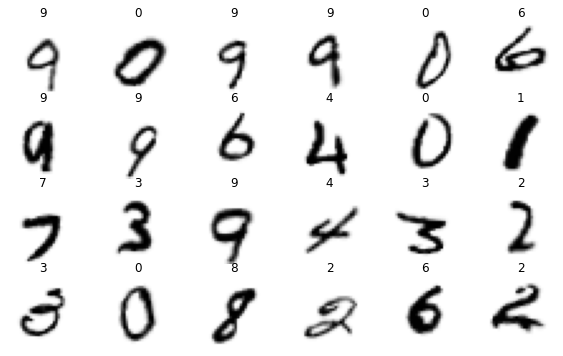

In [10]:
print(dls.vocab) ## Prints class labels
print(dls.c) ## Prints number of classes
dls.show_batch(max_n=24,figsize=(10,6)) ## Show sample data

## Defining Multilayerperceptron using Pytorch

Now we have defined our databunch. Let's define our Multilayer perceptron model using Pytorch. For fully connected layers we used nn.Linear function and to apply non-linearity we use ReLU transformation. In Pytorch, we only need to define the *forward* function, and *backward* function is automatically defined using autograd. If you are new to Pytorch, they provide excellent documentation and tutorials. I would recommend you to go through this [DEEP LEARNING WITH PYTORCH: A 60 MINUTE BLITZ](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) tutorial, it will cover all the basics needed to understand what's happening below.

In [11]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 512, bias=True) 
        self.lin2 = nn.Linear(512, 256, bias=True)
        self.lin3 = nn.Linear(256, 10, bias=True)

    def forward(self, xb):
        x = xb.view(-1,784) ## Equivalent to Flatten in Keras 28*28 -> 784
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        return self.lin3(x)

## Training the model

So now we have defined our Model, we need to train it. We can use FastAI's *Learner* function which makes it easier to leverage modern enhancement in optimization methods and many other neat tricks like  1-Cycle style training as highlighted in [Leslie Smith's paper](https://arxiv.org/pdf/1803.09820.pdf) for faster convergence. Let's define our Learner class -

In [12]:
## Defining the learner
model = Mnist_NN().cuda(0)
mlp_learner = Learner(dls = dls, model=model, pretrained=False, loss_func=F.cross_entropy, metrics=accuracy)

Let's understand what happening by the above arguments-
- *data=data* - Passing our Databunch function
- *model=Mnist_NN()* - Passing our defined MLP model Mnist_NN
- *loss_func=nn.CrossEntropyLoss()* - Defining loss function to optimize, in this case we, are using [cross entropy loss](https://pytorch.org/docs/stable/nn.html?highlight=loss%20crossentropy#torch.nn.CrossEntropyLoss)
- *metrics=accuracy* - It's just for printing purposes while training, this argument have nothing to do with training

*Learner* class provides provide a great function to find the ideal learning rate to start with while training your Deep learning model. Let's try to find the ideal learning rate.

SuggestedLRs(lr_min=0.0033113110810518267, lr_steep=0.002511886414140463)

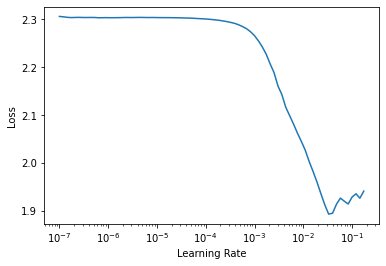

In [13]:
## Finidng Ideal learning late
mlp_learner.lr_find()

Ideally, we want to find the point where there is the maximum slope. In this case, that point is 1e-2. So we will start with 1e-2 as our learning rate and do five epochs using a *fit_one_cycle* function which uses a 1-cycle style training approach as highlighted in [Leslie Smith's paper](https://arxiv.org/pdf/1803.09820.pdf) for faster convergence. Also, FastAI shows' [tqdm](https://tqdm.github.io/) style progress bar while training and at the end of training, it starts showing the table which shows the progress of loss functions and metrics we have defined on validation data.

In [14]:
mlp_learner.fit_one_cycle(5,1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.403407,0.150327,0.953786,01:34
1,0.236453,0.124954,0.963286,01:23
2,0.162708,0.083142,0.974429,01:19
3,0.110618,0.060018,0.981071,01:19
4,0.088329,0.050691,0.984786,01:17


As we can see we are reaching 98.4% accuracy just by using simple Multilayerperceptron in 5 epochs.

## Conclusion

Fast.ai is an excellent initiative by [Jeremy Howard](https://twitter.com/jeremyphoward) and his team, and I believe fastai library can genuinely achieve the motive of democratizing deep learning to everyone by making building deep learning models super simple.

I hope you enjoyed reading, and feel free to use my code to try it out for your purposes. Also, if there is any feedback on code or just the blog post, feel free to reach out on [LinkedIn](https://www.linkedin.com/in/aayushmnit/) or email me at aayushmnit@gmail.com.